# Recommendations with IBM

This notebook explores several different methods of making recommendations to users. The data is from the IBM AI articles platform, provided as part of a Udacity project which formed the basis for this work. The focus will be on making recommendations for users that are already well known to the platform, not on new ones.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Validating our Methods](#Validation)<br>
III. [Rank Based Recommendations](#Rank)<br>
IV. [User-User Based Collaborative Filtering](#User-User)<br>
V. [Content Based Recommendations](#Content-Recs)<br>
VI. [Matrix Factorization](#Matrix-Fact)<br>
VII. [Conclusion](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import auc
from scipy.linalg import subspace_angles
from sklearn.metrics.pairwise import cosine_similarity

import re
from urllib.parse import urlparse

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liams\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liams\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liams\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liams\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Before beginning the work on recommendation methods, it is worth taking some time to explore and understand the data.

In [2]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
df_content.doc_full_name=df_content.doc_full_name.str.lower()

In [5]:
merged_df=pd.merge(df_content, df[['article_id', 'title']].drop_duplicates(), left_on='doc_full_name', right_on='title')

In [6]:
merged_df.apply(lambda row: row.article_id_x == row.article_id_y, axis=1).all()

True

The df and df_content dataframes contain differing sets of articles. I had worried the article id's might be wrong but they do match on titles.

In [7]:
df_no_title=df.drop('title', axis=1)
user_view_counts=df_no_title.groupby('email').count()
user_view_counts.columns=['Views']
article_view_counts=df_no_title.groupby('article_id').count()
article_view_counts.columns=['Views']
user_view_counts.head()

,Views
email,
0000b6387a0366322d7fbfc6434af145adf7fed1,13
001055fc0bb67f71e8fa17002342b256a30254cd,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6
001fc95b90da5c3cb12c501d201a915e4f093290,2


In [8]:
print(user_view_counts.median())
user_view_counts.describe()

Views    3.0
dtype: float64


,Views
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [9]:
article_view_counts.head()

,Views
article_id,
0.0,14
2.0,58
4.0,13
8.0,85
9.0,10


In [10]:
# Find and explore duplicate articles
dupes=df_content.groupby('article_id').count().iloc[:,0] > 1
dupes[dupes].head()

article_id
50     True
221    True
232    True
398    True
577    True
Name: doc_body, dtype: bool

In [11]:
duplicated=df_content.set_index('article_id').sort_index()[dupes]
print(duplicated.shape)
duplicated

(10, 4)


<ipython-input-11-e8c9a7165a9e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  duplicated=df_content.set_index('article_id').sort_index()[dupes]


,doc_body,doc_description,doc_full_name,doc_status
article_id,,,,
50,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,graph-based machine learning,Live
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,graph-based machine learning,Live
221,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,how smart catalogs can turn the big data flood...,Live
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,how smart catalogs can turn the big data flood...,Live
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",self-service data preparation with ibm data re...,Live
232,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",self-service data preparation with ibm data re...,Live
398,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,using apache spark as a parallel processing fr...,Live
398,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,using apache spark as a parallel processing fr...,Live
577,This video shows you how to construct queries ...,This video shows you how to construct queries ...,use the primary index,Live


In [12]:
for idx in set(duplicated.index):
    print(idx)
    print(duplicated.loc[idx].iloc[0]==duplicated.loc[idx].iloc[1])

577
doc_body           False
doc_description    False
doc_full_name       True
doc_status          True
Name: 577, dtype: bool
232
doc_body           False
doc_description     True
doc_full_name       True
doc_status          True
Name: 232, dtype: bool
398
doc_body           False
doc_description     True
doc_full_name       True
doc_status          True
Name: 398, dtype: bool
50
doc_body           False
doc_description    False
doc_full_name       True
doc_status          True
Name: 50, dtype: bool
221
doc_body           False
doc_description    False
doc_full_name       True
doc_status          True
Name: 221, dtype: bool


In [13]:
# Remove any rows that have the same article_id - only keep the first
df_content=df_content.sort_values('article_id').drop_duplicates('article_id',keep='first').set_index('article_id')

In [14]:
#By the numbers
print(f'Number of viewed articles: {article_view_counts.shape[0]}')
print(f'Total number of articles: {df_content.shape}')
print(f'Number of unique users: {user_view_counts.shape[0]}')
print(f'Number of user_article interactions: {df.shape}')

Number of viewed articles: 714
Total number of articles: (1051, 4)
Number of unique users: 5148
Number of user_article interactions: (45993, 3)


In [15]:
#Most viewed articles
article_view_counts.sort_values('Views', ascending=False).iloc[:5]

,Views
article_id,
1429.0,937
1330.0,927
1431.0,671
1427.0,643
1364.0,627


We'll use the email hashes to identify users and then use the order in which users first appear to assign user ID's.

In [16]:
df=df[~df.email.isnull()]

In [17]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df.loc[:,'user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [18]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    articles=df.set_index('article_id').loc[article_ids,'title'].drop_duplicates()
    article_names=list(articles.values)
    
    return article_names

### <a class="anchor" id="Validation">Part II: Validating our Methods</a>

In order to test our recommendation systems we need to fix a validation set and a metric. Since we don't have any temporal data for the user-article interactions there isn't an obvious way to separate into train and validation sets. Similarly we can't know for sure if a user would have liked a recommendation, so we need a proxy to test against.

We will construct the validation set by randomly partitioning the interactions of each user. We will then seek to recommend articles possesing interactions in the validation partition. We're mainly interested in recommendations for users for whom we already have data, so we will drop users with 7 or fewer (for 5 train, 2 test) interactions.

There is a natural precision vs recall tradeoff to our recommendations. If we recommend all the articles we will certainly recommend all the validation articles. If we have a good recommender then we should expect that if we only recommend a few articles then a relatively high proportion will be 'correct'. As we increase the number of recommendations that precision should fall as the recall increase.

The average (over the different users) area under this curve provides a suitable metric for recommender quality.

It is not totally clear how to interpret the number of times a user has viewed an article in this context, so we will only use consider articles as viewed/not viewed. 

In [19]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item=df.groupby(['user_id', 'article_id']).apply(lambda x: 1).unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [20]:
##Collect user lists
known_users=user_item.loc[:,:(df_content.shape[0]-1)].sum(axis=1) > 7 #Find suitable users for validation
known_users=list(user_item[known_users].index)
users=list(user_item.index) #All users

In [21]:
user_train=user_item.loc[known_users,:(df_content.shape[0]-1)].copy()
test={}
seed=42

for user in known_users:
    interactions=user_train.loc[user]
    interactions=interactions[interactions==1]

    test[user]=list(interactions.sample(frac=0.25, random_state=seed).index)
    user_train.loc[user,test[user]]=0
    
    seed= seed+1
    
#user_sim_mat_train=cosine_similarity(user_train)
#user_sim_df_train=pd.DataFrame(user_sim_mat_train, columns=user_train.index, index=user_train.index)

In [22]:
def evaluate_recommender(recommender, test=test, graph=True):
    '''
    Evaluates recommender against a test dictionary. Plots and outputs mean recall, precision and f1-scores.
    Also prints and outputs precision/recall auc score.
    '''
    recalls_list=[]
    precisions_list=[]

    for user in test.keys():   
        recs=recommender(user)
    
        precisions=[]
        recalls=[]
        is_pos=[rec in test[user] for rec in recs]
    
        for i in range(1,900):
            n_true= sum(is_pos[:i])
            precision= n_true/i
            recall=n_true/len(test[user])
        
            precisions.append(precision)
            recalls.append(recall)
        
        recalls_list.append(recalls)
        precisions_list.append(precisions)
    
    mean_precisions=np.array([np.mean(x) for x in np.array(precisions_list).transpose()])
    mean_recalls=np.array([np.mean(x) for x in np.array(recalls_list).transpose()])
    f1_scores=2*(mean_precisions*mean_recalls)/(mean_precisions+mean_recalls)

    pred_auc_score=auc(range(1,900), mean_precisions)      
    recall_auc_score=auc(mean_recalls, mean_precisions)
    
    if graph:
        f, axs = plt.subplots(2,2,figsize=(12,12))

        xlim=100
        plt.subplot(2,1,1)
        plt.plot(range(1,xlim+1), mean_precisions[:xlim])
        plt.plot(range(1,xlim+1), mean_recalls[:xlim])
        plt.plot(range(1,xlim+1), f1_scores[:xlim])
        plt.legend(['Precision', 'Recall', 'f1_score'])
        plt.title('Precision, Recall and f1-score vs Number of Predictions')
        plt.ylabel('Score')
        plt.xlabel('Predictions')
        print(f'Precision/Number of Predictions auc score: {pred_auc_score}')
    
        plt.subplot(2,1,2)    
        plt.plot(mean_recalls, mean_precisions);
        plt.title('Precision vs Recall')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        print(f'Precision/Recall auc score: {recall_auc_score}')
    return mean_precisions, mean_recalls, f1_scores, pred_auc_score, recall_auc_score

### <a class="anchor" id="Rank">Part III: Rank-Based Recommendations</a>

We don't  have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with. That said we do have a choice on how we calculate this. Some users interacted witht the same article several times, which we could choose to factor into our rankings.

We don't do that here, mostly because it is not totally clear how the number of interactions should be interpreted. 

In [23]:
(user_item > 0).sum().sort_values(ascending=False)

article_id
1330.0    467
1429.0    397
1364.0    388
1314.0    345
1398.0    329
         ... 
974.0       1
1233.0      1
1237.0      1
1266.0      1
1119.0      1
Length: 714, dtype: int64

In [24]:
def get_top_articles(n, user_item=user_train):
    '''
    INPUT:
    n - (int) the number of top articles to return
    user_item - (pandas dataframe) user-article interactions maatrix 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_view_counts=(user_item > 0).sum().sort_values(ascending=False)
    top_articles=article_view_counts.head(n).index
    return list(top_articles) # Return the top article titles from df (not df_content)

def rank_recommender(user,n,  user_item=user_train):
    '''
    INPUT:
    user - (str) user for recommendations
    n - (int) the number of recommendations to return
    user_item - (pandas dataframe) user-article interactions maatrix 
    
    OUTPUT:
    recommendations - (list) A list of the top 'n' recommendations by popularity 
    
    '''
    
    return get_top_articles(n, user_train)
    

In [25]:
get_article_names(get_top_articles(10))

['deep learning with tensorflow course by big data university',
 'python machine learning: scikit-learn tutorial',
 'jupyter notebook tutorial',
 'learn tensorflow and deep learning together and now!',
 'the machine learning database',
 'real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)',
 'tensorflow quick tips',
 'access ibm analytics for apache spark from rstudio',
 'practical tutorial on random forest and parameter tuning in r',
 'working interactively with rstudio and notebooks in dsx']

Precision/Number of Predictions auc score: 10.328913413075844
Precision/Recall auc score: 0.026456169308988975


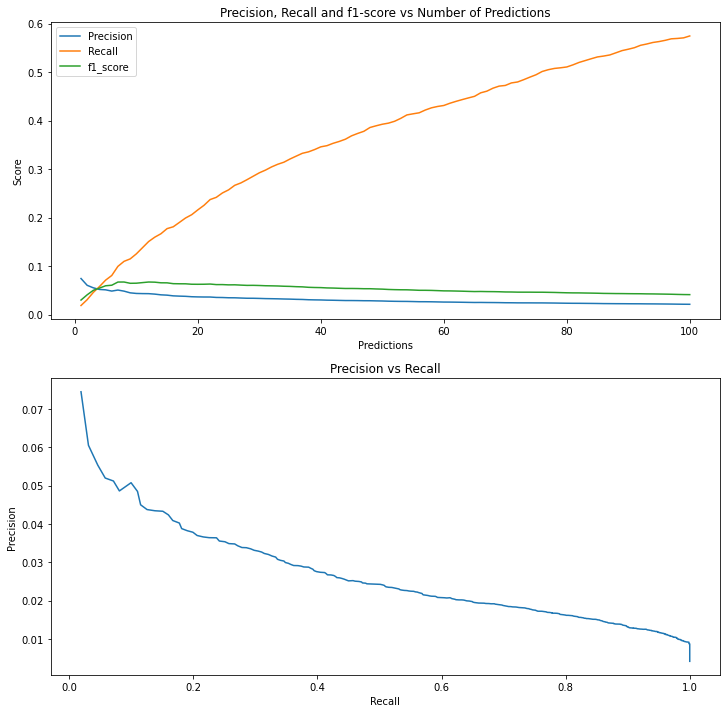

In [26]:
recommender= lambda user: rank_recommender(user,-1, user_train)
evaluate_recommender(recommender,test);

The performance here doesn't seem to be great, but it serves as baseline comparison for other methods.

### <a class="anchor" id="User-User">Part IV: User-User Based Collaborative Filtering</a>

Rather than just using the popularity of each article, we seek to find articles which are popular with 'similar' users. Since we don't have much information about the users we'll measure their similarity based upon their viewing habits. More specifically the similarity of two users will be the cosine angle between their corresponding row vectors in the training user-interaction matrix.

In [27]:
#User similarities for collaborative recommender reimplementation
user_sim_mat=cosine_similarity(user_item)
user_sim_df=pd.DataFrame(user_sim_mat, columns=users, index=users)

user_sim_mat_train=cosine_similarity(user_train)
user_sim_df_train=pd.DataFrame(user_sim_mat_train, columns=user_train.index, index=user_train.index)

user_sim_df.head()

,1,2,3,4,5,6,7,8,9,10,...,5139,5140,5141,5142,5143,5144,5145,5146,5147,5148
1,1.000000,0.136083,0.158114,0.098058,0.000000,0.157135,0.117851,0.132453,0.121716,0.267652,...,0.138458,0.0,0.0,0.157135,0.0,0.074536,0.000000,0.0,0.000000,0.0
2,0.136083,1.000000,0.064550,0.240192,0.000000,0.192450,0.000000,0.054074,0.149071,0.374634,...,0.096900,0.0,0.0,0.000000,0.0,0.182574,0.000000,0.0,0.000000,0.0
3,0.158114,0.064550,1.000000,0.155043,0.091287,0.260875,0.111803,0.104713,0.057735,0.181369,...,0.131353,0.0,0.0,0.186339,0.0,0.141421,0.000000,0.0,0.000000,0.0
4,0.098058,0.240192,0.155043,1.000000,0.339683,0.369800,0.000000,0.207810,0.035806,0.179969,...,0.139648,0.0,0.0,0.092450,0.0,0.175412,0.074125,0.0,0.196116,0.0
5,0.000000,0.000000,0.091287,0.339683,1.000000,0.136083,0.000000,0.229416,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [28]:
def user_seen(user, user_item):
    interactions=user_item.loc[user]
    seen=list(interactions[interactions ==1].index)
    return seen

def user_user_ranked_item(user,user_sim_df=user_sim_df, user_item=user_item, seen=False):
    '''Returns user interaction matrix orderd by user cosine similarity for unseen articles'''
    user_sims=user_sim_df[user].sort_values(ascending=False).drop(user)
    
    if not seen:
        seen = user_seen(user, user_item)
    
    ranked_item=user_item.copy().drop(seen, axis=1)
    ranked_item=ranked_item.reindex(user_sims.index)
    
    return ranked_item

def user_user_scores(ranked_item, weights):
    '''Calculates scores as weighted sum of article interactions'''
    scores=pd.Series(np.array(weights*ranked_item.values)[0], index=ranked_item.columns)
    return scores.sort_values(ascending=False)


def user_user_recs(user, n, ranked_item, decay=-1):
       
    weights=np.matrix([2**(decay*i) for i in range(0,ranked_item.shape[0])])/2
    scores=pd.Series(np.array(weights*ranked_item.values)[0], index=ranked_item.columns)
    scores=scores.sort_values(ascending=False)
    
    return list(scores.index[:n])

def make_user_user_recs(user, n, user_sim_df=user_sim_df, user_item=user_item, decay=-1, seen=False):
    
    '''
    Makes collobarative recommendations.
    
    Ranks other users by similarities. User/article interactions are then weighted by user rank and aggregated.
    
    INPUT:
    user- (int) target of recommendations
    n - (int) number of recommendations
    user_sim_df - (df) user  similarity matrix
    user_item - user/item interaction matrix
    decay - (float) Decay of score contribution interactions, user rank n has weight 2**(n*decay)  
    OUTPUT:
    
    recommendations - list(int) ID's of recommended articles
    '''
    
    ranked_item=user_user_ranked_item(user,user_sim_df, user_item, seen)
    
    return user_user_recs(user, n, ranked_item, decay)

In [29]:
def user_seen(user, user_item):
    interactions=user_item.loc[user]
    seen=list(interactions[interactions ==1].index)
    return seen

This is a slightly weird way of putting the recommender together but it lets us store the ranked_item matrices and quickly churn out recommendations with different rates of decay for comparison.

In [30]:
get_article_names(make_user_user_recs(1,10))

['model bike sharing data with spss',
 'pixieapp for outlier detection',
 'the pandas data analysis library',
 'use sql with data in hadoop python',
 'workflow in r',
 'the nurse assignment problem',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'access mysql with r']

In [31]:
user_ranked_items={user:user_user_ranked_item(user,
                    user_sim_df_train, user_train) for user in user_train.index
                    }


In [32]:
results=dict()

for i in [-1]+[-1+1/k for k in range(2,12)]:
    recommender= lambda user: user_user_recs(user,-1, user_ranked_items[user], decay=i)
    results[i]=list(evaluate_recommender(recommender,test, graph=False))[-2:]
    
results=pd.DataFrame(results, index=['pred_auc_score', 'recall_auc_score']).transpose(
        ).sort_values('recall_auc_score', ascending=False)
results

,pred_auc_score,recall_auc_score
-1.000000,18.795881,0.309319
-0.900000,18.774482,0.309079
-0.909091,18.781202,0.309065
-0.888889,18.772767,0.309040
-0.875000,18.745098,0.306737
-0.857143,18.735959,0.306558
-0.833333,18.720591,0.305374
-0.800000,18.704040,0.303952
-0.750000,18.664876,0.303774
-0.666667,18.303487,0.272919


It looks like performance is about the same for a decay close to $-1$, and better here than the other options, so it's pretty natural to work with this. The performance here is much better than the rank based method (which corresponds to decay=0). 

Precision/Number of Predictions auc score: 18.795880943998313
Precision/Recall auc score: 0.3093191668213908


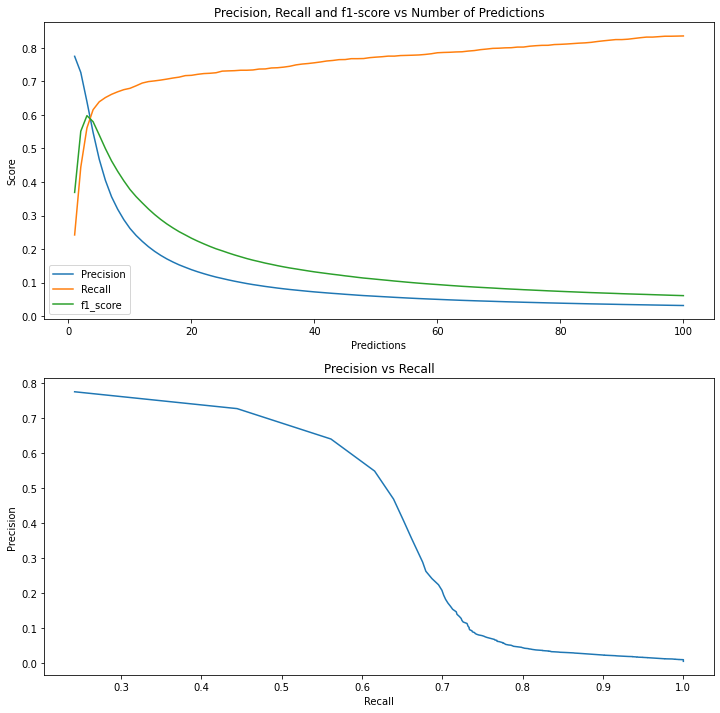

In [33]:
recommender= lambda user: user_user_recs(user,-1, user_ranked_items[user], decay=-1)
evaluate_recommender(recommender,test);

### <a class="anchor" id="Content-Recs">Part V: Content Based Recommendations</a>

Another method we might use to make recommendations is to use some kind of content based analysis. As an example we will tokenize the text data associated to each article and construct a cosine similarity matrix for the articles. This will then be used to find similar articles to those the user has already read.

This method will be the most involved of the options, but roughly speaking it be done by tokenization with nltk, followed by using Tfidf on the resulting word counts. The main addition to the basic nltk tokenisation is to label words with a suffix depnding on where they come from (body/description/name) and to include a basic url parser to identify websites linked to.

In [34]:
def extract_url_data(url):
    """Extract hostname and path from url if possible"""
    dat=urlparse(url)
    if dat.hostname:
        return [x for x in [dat.hostname.strip('www.'), dat.path.strip('/')] if x]
    else:
        dat=urlparse('//'+url)
        return [x for x in [dat.hostname.strip('www.'), dat.path.strip('/')] if x]
url_pattern = r"(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’]))"
stopWords=stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """ Pos tag to Wordnet tag """
    tag=tag[0].upper()
    if tag == 'J':
        return wordnet.ADJ
    elif tag == 'V':
        return wordnet.VERB
    elif tag == 'N':
        return wordnet.NOUN
    elif tag == 'R':
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [35]:
def tokenize(text, suffix=''):
    """Clean and tokenize text, then lemmatize. Label with suffix if given"""
    text = text.lower()

    ##urls
    text=re.sub(r"\[|\]", ' ', text) #They break the regex for some reason

    matcher= re.compile(url_pattern)
    urls=[match.group() for match in matcher.finditer(text)]
    for url in urls:
        text=text.replace(url, ' ', 1)

    url_tokens=sum([extract_url_data(url) for url in urls], [])

    ##Remove punctuation and tokenize
    text = re.sub(r"[^a-zA-Z]", " ", text)

    word_tokens=word_tokenize(text)
    ##Lemmatise
    word_tokens = [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) for word,tag in pos_tag(word_tokens) if word not in stopWords]
    #word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stopWords]
    return [token+suffix for token in (url_tokens+word_tokens)]

def tokenizer(suffix):
    '''Tokenize wrapper'''
    return (lambda text: quick_tokenize(text,suffix=suffix))

def quick_tokenize(text, suffix=''):
    """Clean and tokenize text, then lemmatize"""
    text = text.lower()

    ##Remove punctuation and tokenize
    text = re.sub(r"[^a-zA-Z]", " ", text)

    word_tokens=word_tokenize(text)
    ##Lemmatise
    word_tokens = [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) for word,tag in pos_tag(word_tokens) if word not in stopWords]
    #word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stopWords]
    return [token+suffix for token in word_tokens]

In [36]:
def transformer(suffix,vect=None):
    '''Make feature pipeline for text tokenisation'''
    if vect==None:
        vect=CountVectorizer(tokenizer=tokenizer(suffix))
        
    features=Pipeline([('pull_column', FunctionTransformer(lambda df : df['doc'+suffix], validate=False)),
                           ('vect', vect)])
    return features

In [37]:
df_content.fillna('', inplace=True)

In [38]:
def build_transformer(X, suffixes=['_body', '_description', '_full_name']):
    '''Text vectoriser + tfidf transform for given suffixes'''
    if len(suffixes) > 1:
        text_transformer=FeatureUnion([('transformer'+suffix,transformer(suffix)) for suffix in suffixes])
    else:
        text_transformer=transformer(suffixes[0])
        
    pipe=Pipeline([('text_vects', text_transformer),
                            ('tfidf', TfidfTransformer())])    
    X=pipe.fit_transform(X)
    return X, pipe

tfidf_df, text_transformer=build_transformer(df_content)

In [39]:
art_sim_mat=cosine_similarity(tfidf_df)
art_sim_df=pd.DataFrame(art_sim_mat, columns=df_content.index, index=df_content.index)

In [40]:
def build_keyword_transformer(X, suffixes=['_body', '_description'], key_suffix='_full_name'):
    '''Build, fit and transform keyword tranformer'''
    
    
    vect=CountVectorizer(tokenizer=tokenizer(key_suffix))

    key_transformer=transformer(key_suffix, vect)
    
    key_transformer.fit(X)
    
    key_word_transformer=FeatureUnion([('transformer'+key_suffix, key_transformer)]+
                                          [('transformer'+suffix,transformer(suffix, vect)) for suffix in suffixes])
    

    tfidf=TfidfTransformer()
    
    X_count=key_word_transformer.transform(X)
    
    X_tfidf=tfidf.fit_transform(X_count)
    
    pipe=Pipeline([('key_word_vects', key_word_transformer),
                            ('tfidf', tfidf)]) 
    
    return X_tfidf, pipe

#tfidf_df, text_transformer=build_keyword_transformer(df_content)

In [41]:
def content_angle_recs(seen,sim_df=art_sim_df, agg=lambda x: x.mean(axis=1)):
    '''Content recommender based on cosine similarity'''
    
    unseen_sim=sim_df.drop(seen).loc[:,seen]
    agg_sim=agg(unseen_sim).sort_values(ascending=False)
    
    return agg_sim
def make_content_angle_recs(user, n, sim_df=art_sim_df, user_item=user_item, agg=lambda x: x.mean(axis=1)):
    '''
    Makes content recommendations.
    
    INPUT:
    user- (int) target of recommendations
    n - (int) number of recommendations
    sim_df - (df) article similarity matrix
    user_item - user/item interaction matrix
    agg = (row -> float) method for aggregating similarity scores
    
    OUTPUT:
    (list) n content based recommendations for user
    
    '''
    user_item=user_item.reindex(art_sim_df.columns, axis=1).dropna(axis=1)
    interactions=user_item.loc[user]
    seen=list(interactions[interactions ==1].index)
    agg_sim=content_angle_recs(seen, sim_df=sim_df, agg=lambda x: x.mean(axis=1))
    
    return list(agg_sim.index)[:n]

In [42]:
get_article_names(make_content_angle_recs(1,10)) #Example

['python machine learning: scikit-learn tutorial',
 '10 powerful features on watson data platform, no coding necessary',
 'breaking the 80/20 rule: how data catalogs transform data scientists’ productivity',
 'data tidying in data science experience',
 'make machine learning a reality for your enterprise',
 'machine learning for the enterprise',
 'predicting flight cancellations using weather data, part 3',
 'jupyter notebooks with scala, python, or r kernels',
 'learn tensorflow and deep learning together and now!',
 'continuous learning on watson']

In [43]:
#tfidf_df, text_transformer=build_transformer(df_content,suffixes=['_description', '_full_name'])
art_sim_mat_train=cosine_similarity(tfidf_df)
art_sim_df_train=pd.DataFrame(art_sim_mat_train, columns=df_content.index, index=df_content.index)
art_sim_df_train=art_sim_df_train.loc[user_train.columns, user_train.columns]

Precision/Number of Predictions auc score: 7.632642888288499
Precision/Recall auc score: 0.011919045573957796


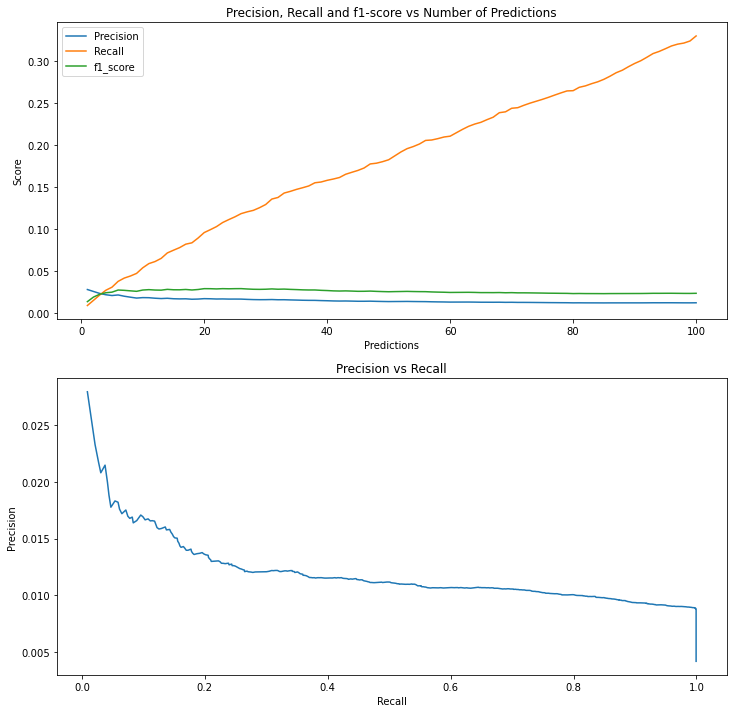

In [44]:
recommender =lambda user: make_content_angle_recs(user,-1, art_sim_df_train, user_train)
evaluate_recommender(recommender);

We can improve the perfomance somewhat by using only the description and name of the article. This more closely mirrors how people choose to read articles, plus the content data is not very clean. If we load up the article body below, for instance, we see that there's a bunch of stuff at the bottom which is totally irrelevant to the actual article.

Unfortunately there doesn't seem to be any overarching rules for where this kind of unhelpful content comes in the document body, so it is difficult to only focus on the useful parts. Just using the name and description can help sidestep this issue, though there are still similar problems with some descriptions, but to a lesser extent.

In [45]:
print(df_content.loc[3, 'doc_body'])

DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCALE - BOOST THE PERFORMANCE OF YOUR
DISTRIBUTED DATABASE
Share on Twitter Share on Facebook Share on Google+ Vote on Hacker News Published Dec 29, 2016Learn how distributed DBs (Cassandra, MongoDB, RethinkDB, etc) solve the problem
of scaling persistent storage, but introduce latency as data size increases and
become I/O bound. In single server DBs, latency is solved by introducing
caching. In this talk, Akbar Ahmed shows you how to improve the performance of
distributed DBs by using a distributed cache to move the data layer performance
limitation from I/O bound to network bound.

Akbar is the CEO and founder of DynomiteDB, a framework for turning single
server data stores into linearly scalable, distributed databases. He is an
Apache Cassandra certified developer and a Cassandra MVP, enjoys the
expressiveness of both SQL and alternative query languages, and evaluates the
entire database ecosystem every 6 months and has an MBA in Informatio

In [46]:
tfidf_df, text_transformer=build_transformer(df_content,suffixes=['_description', '_full_name'])
art_sim_mat_train=cosine_similarity(tfidf_df)
art_sim_df_train=pd.DataFrame(art_sim_mat_train, columns=df_content.index, index=df_content.index)
art_sim_df_train=art_sim_df_train.loc[user_train.columns, user_train.columns]

Precision/Number of Predictions auc score: 8.021604808960213
Precision/Recall auc score: 0.01352498923654916


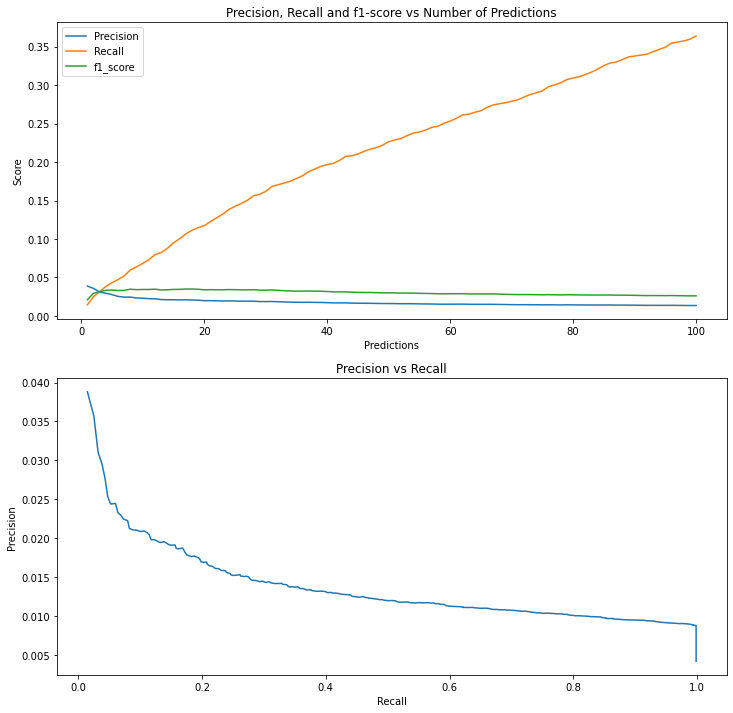

In [47]:
recommender =lambda user: make_content_angle_recs(user,-1, art_sim_df_train, user_train)
evaluate_recommender(recommender);

This method isn't great, in fact it's worse than just recommending articles by populairty. Partly this is because the implementation isn't as good as it could be. There are also some more fundamental problems however. 

The model correctly identifies very similar articles but this doesn't always translate into good recommendations. One particular issue is that some articles are videos. They have very similar content according to df_content but may be very different in reality.

There is also series of newsletters which are all identified as being similar. If someone has read a few of these newsletters they'll be recommended all of the rest. This might make sense as a recommendation but is often a poor performing choice. In some ways this reflects a limitation of our evaluation method, we're constrained to asking whether someone has already seen a recommendation, which might not always be a good measure of the quality of a recommendation.

This seems to be less of an issue with the collaborative method. This may reflect the nature of content discovery. Some articles might be 'popular' just because they are widely disseminated, for example if it was an article pinned on the home page. The existing data is biased towards articles which were more visible, and this is recreated in the collaborative model in a way that it is not in the content based model.

We can also combine the previous two methods. Instead of making a collaborative recommendation based on only articles that other users have seen, we can include a contribution from similar articles. 

In the original method for example, if user $X_{n}$ is the $n^{th}$ most similar user we a contribution of $\frac{1}{2^{n}}$ towards the score of each article $X_{n}$ has seen. Instead we might say that for each article $A_{i}$ seen by $X$ and each other article $A_{j}$ add $$\frac{f(C(A_{i},A_{j})}{2^{n}}$$ to the score of $A_{j}$, where $C(A_{i},A_{j})$ is the cosine angle.

In [48]:
mult=np.matrix(user_train)*(art_sim_df_train**2).values

In [49]:
content_item=pd.DataFrame(np.array(mult), index=user_train.index, columns=user_train.columns)

Precision/Number of Predictions auc score: 17.400122547003498
Precision/Recall auc score: 0.23189749559810388


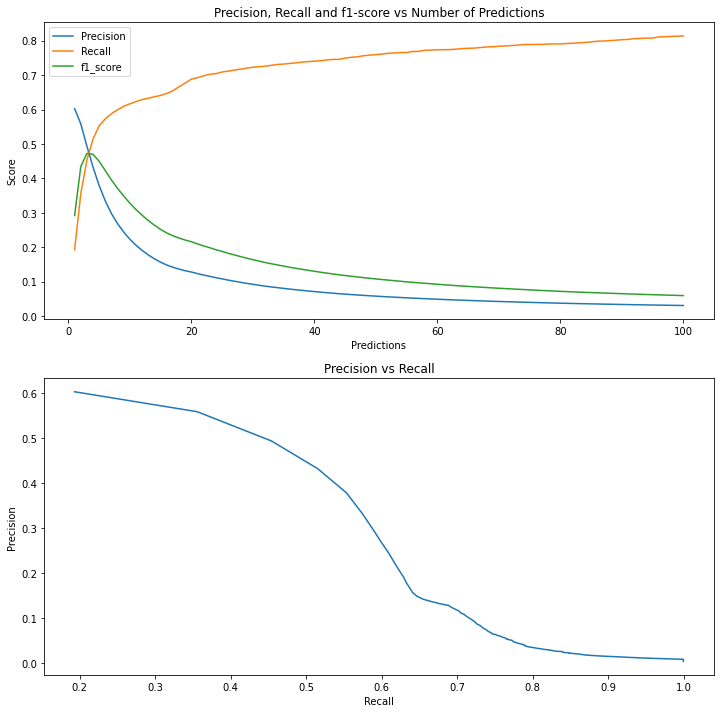

In [50]:
recommender =lambda user: make_user_user_recs(user, -1, user_sim_df=user_sim_df_train, user_item=content_item,
                                              decay=-1, seen = user_seen(user, user_train))
evaluate_recommender(recommender);

Unsurprisngly this is worse than our first method, but an improvement on the second. With a better content based method, however, it might become a more viable option.

### <a class="anchor" id="Matrix-Fact">Part VI: Matrix Factorization</a>


The final recommendation method to try uses singular value decomposition. 

Given a user-article interaction matrix, $M$, we can take a singular value decomposition
$$M=USV^{T}$$
where $S$ is a diagonal matrix of singular values (these can be thought of as generalised eigenvalues, or just the square roots of the eignevalues of $MM^{T}$) and $U,V$ are semi-unitary matrices so that $$U^{T}U=V{T}V=I.$$

The idea then is that the variability of the matrix should be captured by the large singular values, so if we truncate $S$ we should be able to capture the behaviour of the matrix $M$ while throwing away some of the irrelevant information. Then we make recomendation bases on the entries of this new, approximate matrix.

Often such methods are used in conjunction with latent variables. That there should be some underlying linear structure which determines user/article interactions and these should correspond to the large singular values.

In [51]:
def restructure_SVD(k, u, s, vt):

    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    return np.dot(np.dot(u_new, s_new), vt_new)

def SVD_recs(user, n, svd_mat):
        
    scores=svd_mat.loc[user]
    scores=scores.sort_values(ascending=False)
    return list(scores.index[:n])

def make_SVD_recs(user, n , k, user_item=user_item):
    
    u, s, vt =np.linalg.svd(user_item)
    
    svd_mat=pd.DataFrame(restructure_SVD(k,u,s,vt), index=user_item.index, columns=user_item.columns)
    svd_mat[user_item==1]=-1
    
    return SVD_recs(user, n, svd_mat)

In [52]:
get_article_names(make_SVD_recs(1, 10 , 100, user_item))

['use the machine learning library',
 'data science for real-time streaming analytics',
 'top 10 machine learning algorithms for beginners',
 "a kaggler's guide to model stacking in practice",
 'shiny 0.12: interactive plots with ggplot2',
 'predict chronic kidney disease using spss modeler flows',
 'what caused the challenger disaster?',
 'breast cancer wisconsin (diagnostic) data set',
 'flexdashboard: interactive dashboards for r',
 'small steps to tensorflow']

In [53]:
u_train, s_train, vt_train =np.linalg.svd(user_train)

results=dict()

num_latent_feats = np.arange(50,150,5)
for k in num_latent_feats:

    svd_mat=pd.DataFrame(restructure_SVD(k, u_train, s_train, vt_train),
                         index=user_train.index, columns=user_train.columns)
    svd_mat[user_train==1]=-1
    
    recommender = lambda user: SVD_recs(user,-1, svd_mat)
    results[k]=list(evaluate_recommender(recommender,test, graph=False))[-2:]
    

results=pd.DataFrame(results, index=['pred_auc_score', 'recall_auc_score']).transpose(
        ).sort_values('recall_auc_score', ascending=False)
results.head()

,pred_auc_score,recall_auc_score
120,13.068915,0.072517
115,13.165446,0.071990
110,13.168945,0.071963
130,13.017742,0.071351
125,13.039930,0.071305


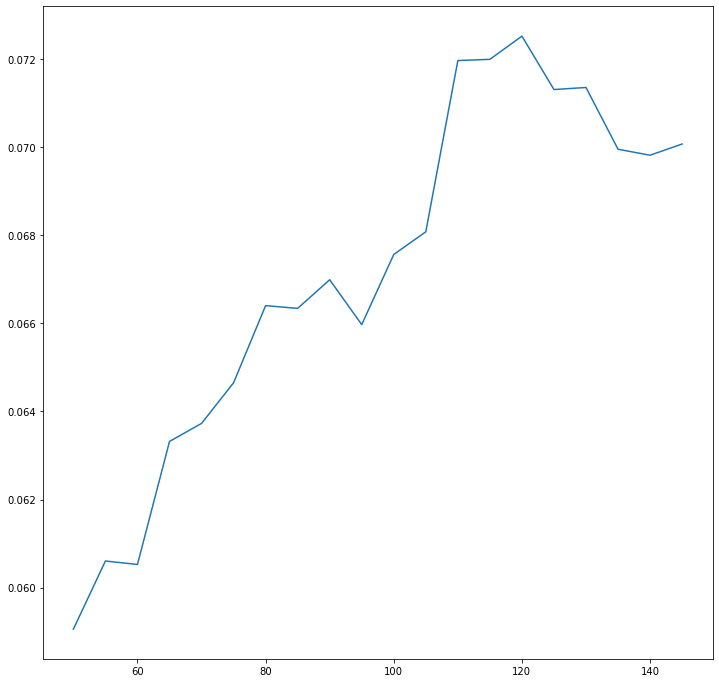

In [54]:
f, axs = plt.subplots(1,1,figsize=(12,12))
plt.plot(results.sort_index().recall_auc_score)

Precision/Number of Predictions auc score: 13.03992990741326
Precision/Recall auc score: 0.07130490456137849


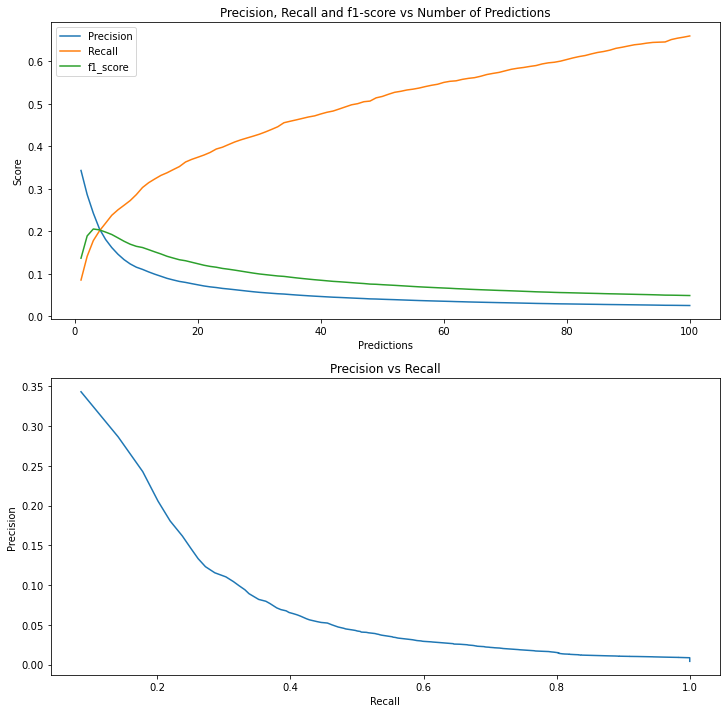

In [55]:
svd_mat=pd.DataFrame(restructure_SVD(125, u_train, s_train, vt_train),
                         index=user_train.index, columns=user_train.columns)
svd_mat[user_train==1]=-1
    
recommender = lambda user: SVD_recs(user,-1, svd_mat)
evaluate_recommender(recommender,test);
    

Once again, the method is not fantastic. With 125 latent features, it is better than the content based method, but worse than the collaborative one and similar to the combined one.

Unlike the earlier methods this one more naturally offers a variable number of recommendations. The SVD method ultimately produced a matrix of values, where in a perfect world $1$ would mean it should be recommended and $0$ means it should not.

We can therefore fix a threshold $t$ and recommend articles to users for whom the corresponding matrix value is at least $t$.

In [56]:
def SVD_threshold_scores(user, svd_mat, seen):
        
    scores=svd_mat.loc[user]
    scores=scores.sort_values(ascending=False)
    scores=scores.drop(seen)
    
    
    return scores

def make_SVD_threshold_recs(user, t , k, user_item=user_item):
    
    u, s, vt =np.linalg.svd(user_item)
    
    svd_mat=pd.DataFrame(restructure_SVD(k,u,s,vt), index=user_item.index, columns=user_item.columns)
    
    seen=user_seen(user,user_item)
    scores= SVD_threshold_scores(user, svd_mat, seen)
    
    
    return list((scores[scores >= t]).index)

In [57]:
def evaluate_threshold_recommender(recommender, test=test, user_train=user_train, graph=True):
    '''
    Evaluates recommender against a test dictionary. Plots and outputs mean recall, precision and f1-scores.
    Also prints and outputs precision/recall auc score.
    '''
    recalls_list=[]
    precisions_list=[]
    n_recs_list=[]
    
    for user in test.keys():   
        
        precisions=[]
        recalls=[]
        n_recs=[]
        
        scores=recommender(user)
        
        for t in np.linspace(0,1,101):
            
            recs=scores[scores >= t].index
            if len(recs) > 0:
                is_pos=[rec in test[user] for rec in recs]
                n_true= sum(is_pos)
                precision= n_true/len(is_pos)
                recall=n_true/len(test[user])
            else:
                precision=1
                recall=0
            
            precisions.append(precision)
            recalls.append(recall)
            n_recs.append(len(recs))
        
        recalls_list.append(recalls)
        precisions_list.append(precisions)
        n_recs_list.append(n_recs)
    
    mean_precisions=np.array([np.mean(x) for x in np.array(precisions_list).transpose()])
    mean_recalls=np.array([np.mean(x) for x in np.array(recalls_list).transpose()])
    mean_n_recs=np.array([np.mean(x) for x in np.array(n_recs_list).transpose()])
    f1_scores=2*(mean_precisions*mean_recalls)/(mean_precisions+mean_recalls)
    
    recall_auc_score=auc(mean_recalls, mean_precisions)
    
    if graph:
        f, axs = plt.subplots(1,1,figsize=(12,12)) 
        plt.plot(mean_recalls, mean_precisions);
        plt.title('Precision vs Recall')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        print(f'Precision/Recall auc score: {recall_auc_score}')
    return mean_precisions, mean_recalls, f1_scores, mean_n_recs, recall_auc_score

Precision/Recall auc score: 0.1738330992009118


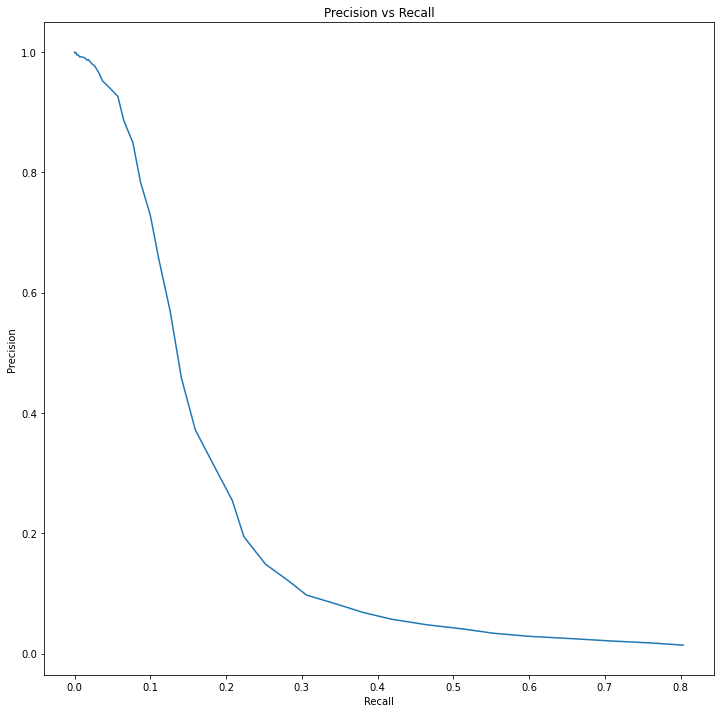

In [58]:
seen_dict={user:user_seen(user,user_train) for user in test.keys()}

recommender = lambda user: SVD_threshold_scores(user, svd_mat, seen_dict[user])
evaluate_threshold_recommender(recommender,test);

The auc score here is much higher, though it is not directly comparable to the earlier scores since the test is slightly different here. In particular the high precision at the start is essentially achieved by not making any recommendations at high thresholds. For comparison we can do the same thing with the other recommenders, though it is much less natural.

Precision/Recall auc score: 0.5945420979559739


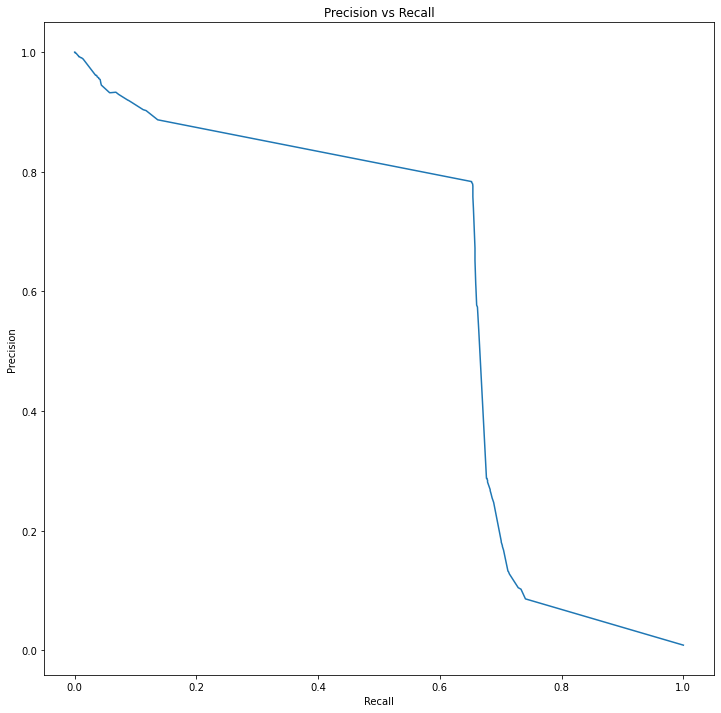

In [59]:
ranked_item_dict={user:user_user_ranked_item(user,user_sim_df_train, user_train) for user in test.keys()}
weights=np.matrix([2**(-i) for i in range(0,user_item.shape[0])])/2
recommender=lambda user: user_user_scores(ranked_item_dict[user], weights[:,:ranked_item_dict[user].shape[0]])

mean_precisions, mean_recalls, f1_scores, mean_n_recs, recall_auc_score=evaluate_threshold_recommender(recommender,test);

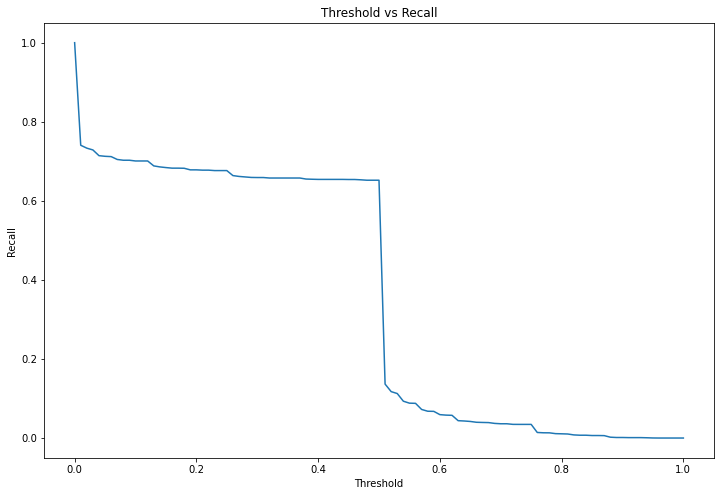

In [60]:
plt.subplots(1,1,figsize=(12,8)) 
plt.plot(np.linspace(0,1,101), mean_recalls)
plt.title('Threshold vs Recall')
plt.xlabel('Threshold')
plt.ylabel('Recall');

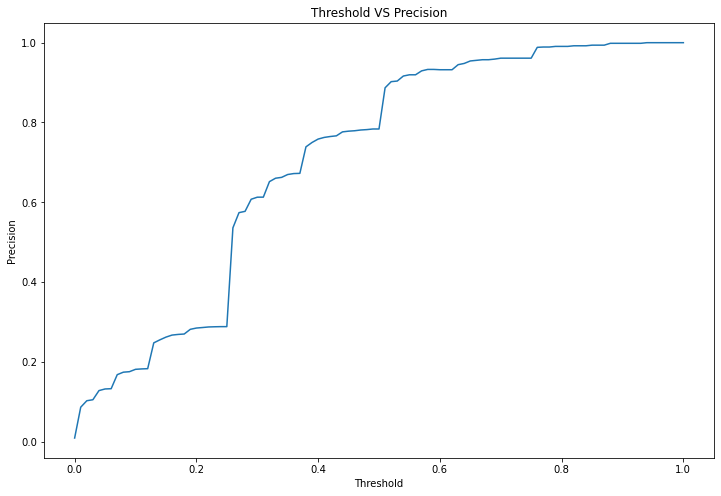

In [61]:
plt.subplots(1,1,figsize=(12,8)) 
plt.plot(np.linspace(0,1,101), mean_precisions)
plt.title('Threshold VS Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision');

As before this method performs very very well. If we were to use the method like this we would want to pick a threshold of about 0.45.

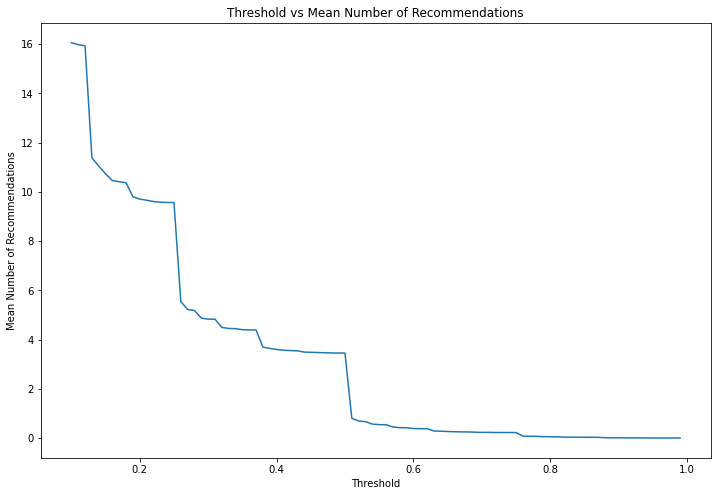

In [62]:
plt.subplots(1,1,figsize=(12,8)) 
plt.plot(np.linspace(0,1,101)[10:100], mean_n_recs[10:100])
plt.title('Threshold vs Mean Number of Recommendations')
plt.xlabel('Threshold')
plt.ylabel('Mean Number of Recommendations');

In [63]:
n_recs=[]

for user in test.keys():   
        scores=recommender(user)
        recs=scores[scores >= 0.45].index
        n_recs.append(len(recs))
        
f'Number of users with no recommendations: {len([n for n in n_recs if n==0])}'

'Number of users with no recommendations: 11'

This only gives a few recommendations though, and gives some users none at all. This style of recommendation making, therefore, may not be appropriate for some uses. On the other hand a a high threshold is very restrictive and if we were interested in making only a few, accurate recommendations to some users, this could be a very powerful method.

### <a class="anchor" id="Conclusion">Part VII: Conclusion</a>

We've seen a few different methods for making recommendations with this data set. The collaborative method is the clear winner against the metric we originally specified, the precision-recall AUC score. However other methods may be more useful in making certain kinds of recommendations. For example if we wished to put recommendations for what to read next at the bottom of an article then a content based method may be more appropriate. They may have other benefits like more serendipitous recommendations, which are not really tested by our metric.

There is also more scope for combining the methods than has been done here. If we were trying to make $n$ recommendations, say, we might wish to make some by different methods, or even choose $2n$ with one method, and then make a final pick of $n$ with another. In the latter case we might want to replace the SVD method with one closer to FunkSVD, by 'hiding' the user-item entries corresponding to possible recommendations we could use FunkSVD to get a decomposition which doesn't take into account that these entries are $0$, which may improve perfomance.


In any case, once we had suitably refined our models we would likely wish to test their real world performance. This could be done through A/B testing. 

Since we have multiple models, some of which we may wish to blend, we may either run multiple experiments in tandem, and make pairwise  or group comparisons, or opt for a more iterative approach. This might look like testing two options, picking the better, and testing it against a new option and so on. The timescale of the experiment might look very different depending on the choices made, and this should be taken into account.

It would not really be appropriate here to test against a system with no, or totally random, recommendations. This would likely severely impact the user experience of one group, which would be at best questionably ethical and at worst detrimental to the overall platform. Comparisons against historical data would likely be flawed as there may be novelty bias, or unrelated changes in user behaviour, however such data could be used effectively to assign users to testing groups.

For either situation we would need to fix relative metrics in advance. The most natural here is a user-engagement metric, say mean number of articles interacted with. We might also be interested in user retention, perhaps measured by the number of users who interact with at least one article in the final $n$ days. Subsidiary items of interest might focus on the distribution of interactions. IBM might seek for example to increase the number of interactions with less popular articles, either as a goal in its own right or as part of a longer term aim to increase the diversity of articles.

Finally, the users of this site are likely more technologically minded than the global average. They may, therefore, be interested in being afforded the opportunity to choose the way recommendations are made themselves, within some preset limits. If a model blending collaborative and content based recommendations was used, the option might be given to chose the relative weighting of each method. The Steam store, for example, offers something along these lines.

It would be difficult, I expect, to get a good idea of the effectiveness of such an option in the short term as there would likely be a large novelty factor. Equally there may be objections if such a feature was rolled out long term to only a subset of users, especially if it proved popular. Conversely comparisons between users who engaged with this feature and those who did not would be poor as they suffer from inherent sample bias. 